In [1]:

import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/shadow_with_aug_selection_sasrec_on_sr_data_lr0.01_lstep20/Amazon_Beauty_8000_Round_Eval_result_for_method_1"
config_path = os.path.join(eval_folder_path, "config.yaml")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")
print_log_path = os.path.join(eval_folder_path, "exp_print.log")


In [2]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [7]:
import re
## Parse exp_print.log for each experiment
"""
2024-09-18 18:29:02,015 (shadow_client_and_server:97) INFO: ----------- Starting training (Round #0) -------------
2024-09-18 18:29:02,016 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 1, 'shadow_client': 6610}
2024-09-18 18:29:02,016 (shadow_client_and_server:635) INFO: Examining augmentation set for training
2024-09-18 18:29:02,191 (shadow_client_and_server:507) INFO: Augmentation Rank for client # 6610 : [2 1 3 4 5 7 0 6]
2024-09-18 18:29:02,204 (shadow_client_and_server:644) INFO: Selected the most generalized augmentation set for training
2024-09-18 18:29:03,197 (shadow_client_and_server:700) INFO: {'Role': 'Client #6610', 'Round': 0, 'Results_raw': {'train_avg_loss': 8.992909, 'train_loss': 179.85817, 'train_total': 20, 'train_recall_10': 0.0, 'train_recall_20': 0.0, 'train_ndcg_10': 0.0, 'train_ndcg_20': 0.0}}
2024-09-18 18:29:03,198 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 2, 'shadow_client': 22282}
"""

def extract_rank(text : str) -> List[int]:
    """
    Extract the rank from the text.
    """
    pattern = r'\[(.*?)\]'
    match = re.search(pattern, text)
    if match:
        # Convert the string of numbers into a list of integers
        num_list = list(map(int, match.group(1).split()))
        return num_list
    
    
def extract_flag(text : str) -> int:
    """
    Extract the flag from the text.
    """
    pattern = r'\b(generalized|personalized)\b'
    match = re.search(pattern, text)
    if match:
        keyword = match.group(0)
        return 0 if keyword == "personalized" else 1

## Record Via Each Runs Later Divide by client sample size
personalized_or_genearlizaed = [] ## 0 for personalized, 1 for generalized
ranks = [] 
personalized_rank = []
generalized_rank = []

current_rank = None
current_aug_flag = None
for line in load_log_file(print_log_path).split("\n"):
    if "shadow_client_and_server:507" in line:
        ## parse the list at the end
        current_rank = extract_rank(line)
        ranks.append(current_rank)
        
    elif "shadow_client_and_server:644" in line:
        current_aug_flag = extract_flag(line)
        personalized_or_genearlizaed.append(current_aug_flag)
        if current_aug_flag == 0:
            personalized_rank.append(current_rank)
        else:
            generalized_rank.append(current_rank)
        
    ## (shadow_client_and_server:292) == Reward and Distribution of MAP

## 1. In the progression of the rounds, does personalized aug used more? or generalization aug used more?
## 2. In presonalization, which aug method is used more?
## 3. In generalization, which aug method is used more?



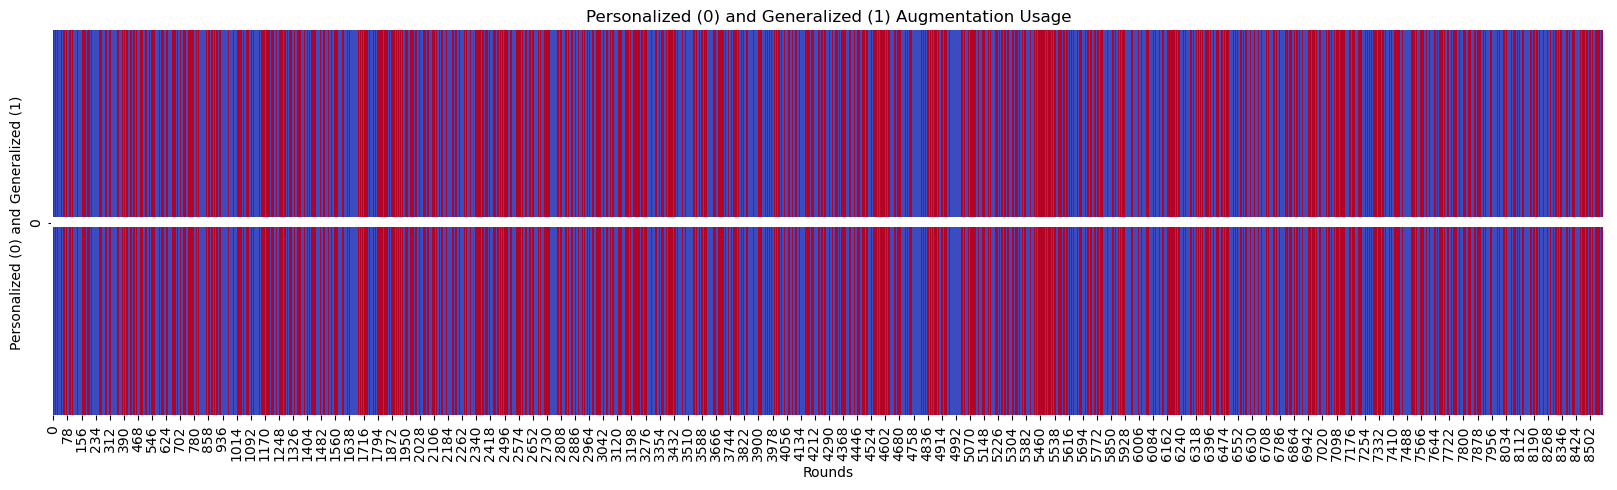

In [9]:
## Visualize use of personalized and generalized augmentation
## as a 1d heatmap
## since each round has 16 client samples, we can divide the number of personalized and generalized by 16

heat_map_data = []
for i in range(0, len(personalized_or_genearlizaed), 16):
    heat_map_data.append(personalized_or_genearlizaed[i])

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(20, 5))
sns.heatmap([heat_map_data], cmap='coolwarm', cbar=False, annot=True)
plt.title("Personalized (0) and Generalized (1) Augmentation Usage")
plt.xlabel("Rounds")
plt.ylabel("Personalized (0) and Generalized (1)")
plt.show()


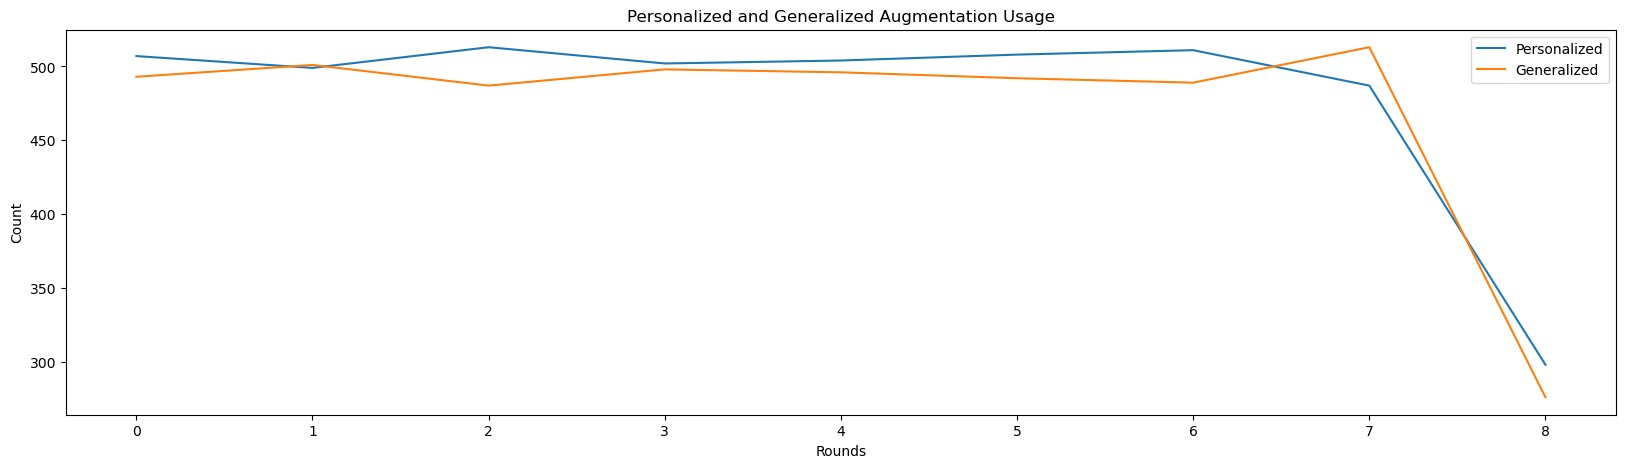

In [11]:
## in every 1000th round how many personalized and generalized aug are used
## histogram

personalized_count = 0
generalized_count = 0
personalized_counts = []
generalized_counts = []

for i in range(0, len(heat_map_data), 1000):
    for j in range(i, i+1000):
        try :
            if heat_map_data[j] == 0:
                personalized_count += 1
            else:
                generalized_count += 1
        except:
            pass
    personalized_counts.append(personalized_count)
    generalized_counts.append(generalized_count)
    personalized_count = 0
    generalized_count = 0

plt.figure(figsize=(20, 5))
plt.plot(personalized_counts, label="Personalized")
plt.plot(generalized_counts, label="Generalized")
plt.title("Personalized and Generalized Augmentation Usage")
plt.xlabel("Rounds")
plt.ylabel("Count")
plt.legend()
plt.show()


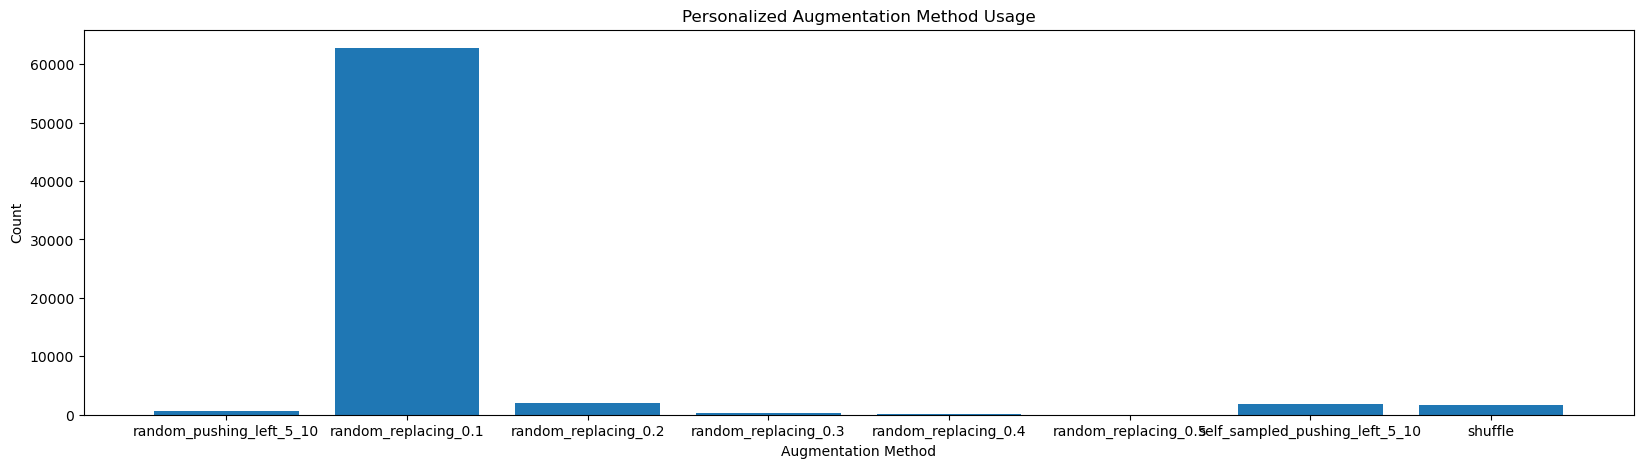

In [13]:
## In personalized augmentation, which augmentation method is used more?
## Get the count of the first ranks of each aug methods
"""
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_pushing_left_5_10
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_replacing_0.1
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_replacing_0.2
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_replacing_0.3
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_replacing_0.4
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/random_replacing_0.5
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/self_sampled_pushing_left_5_10
    - ../../../../data1/donghoon/FederatedScopeData/Amazon_Beauty_5core/shuffle
"""
## 8 bins
personalized_rank_counts = [0] * 8
bin_key_words = ["random_pushing_left_5_10", "random_replacing_0.1", "random_replacing_0.2", "random_replacing_0.3", "random_replacing_0.4", "random_replacing_0.5", "self_sampled_pushing_left_5_10", "shuffle"]

for i in range(0, len(personalized_rank)):
    personalized_rank_counts[personalized_rank[i][0]] += 1

plt.figure(figsize=(20, 5))
plt.bar(bin_key_words, personalized_rank_counts)
plt.title("Personalized Augmentation Method Usage")
plt.xlabel("Augmentation Method")
plt.ylabel("Count")
plt.show()


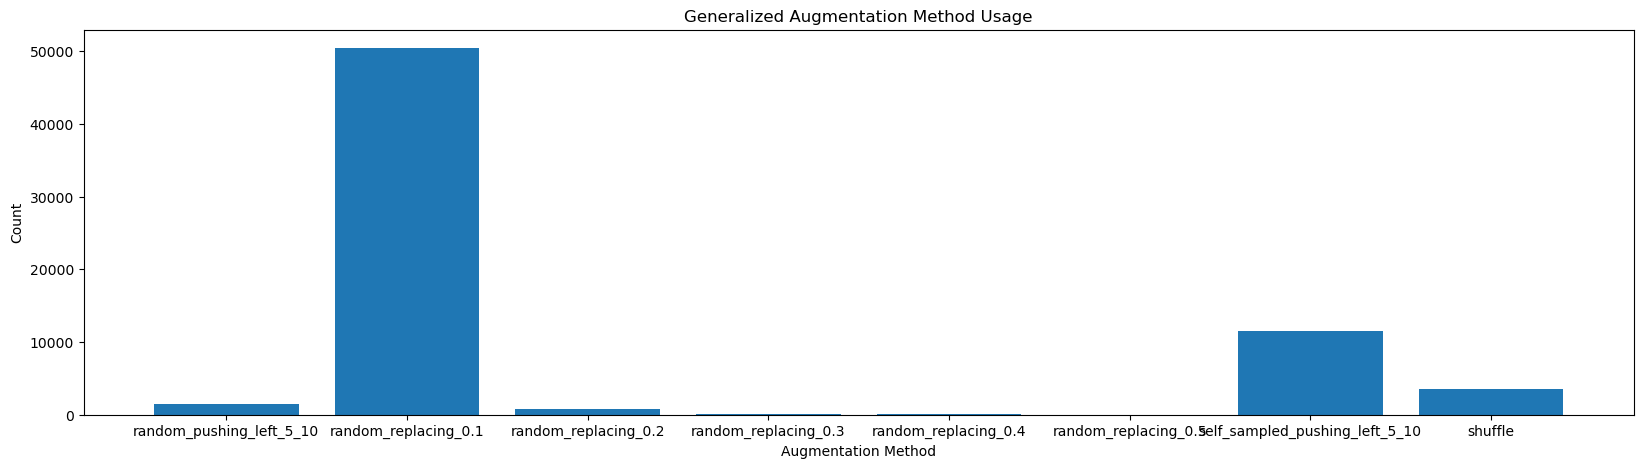

In [14]:
## In generalization augmentation, which augmentation method is used more?

generalized_rank_counts = [0] * 8
for i in range(0, len(generalized_rank)):
    generalized_rank_counts[generalized_rank[i][0]] += 1
    
plt.figure(figsize=(20, 5))
plt.bar(bin_key_words, generalized_rank_counts)
plt.title("Generalized Augmentation Method Usage")
plt.xlabel("Augmentation Method")
plt.ylabel("Count")
plt.show()


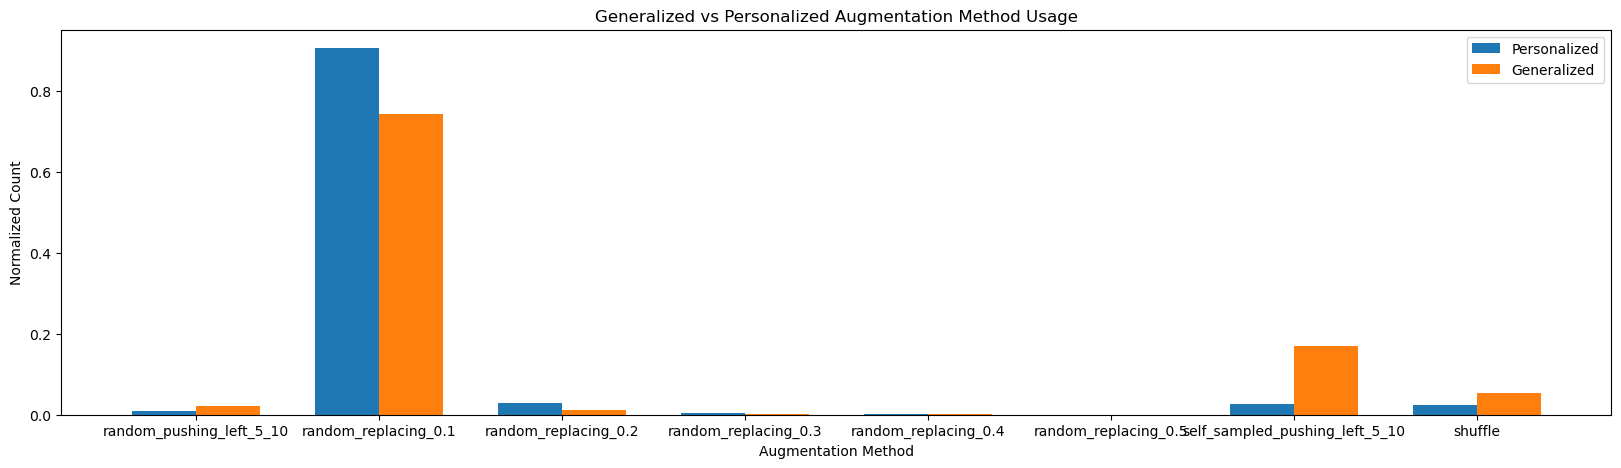

In [18]:
## Lets Compare Generalization vs Personalization normalized count comparison
## except the method #1

personalized_rank_counts_normalized = [0] * 8
generalized_rank_counts_normalized = [0] * 8

personalized_sum = len(personalized_rank)
generalized_sum = len(generalized_rank)

for i in range(0, 8):
    personalized_rank_counts_normalized[i] = personalized_rank_counts[i] / personalized_sum
    generalized_rank_counts_normalized[i] = generalized_rank_counts[i] / generalized_sum


plt.figure(figsize=(20, 5))
## side by side
## personalization at the left
## generalization at the right
bar_width = 0.35
index = np.arange(8)
plt.bar(index, personalized_rank_counts_normalized, bar_width, label="Personalized")
plt.bar(index + bar_width, generalized_rank_counts_normalized, bar_width, label="Generalized")
plt.xticks(index + bar_width / 2, bin_key_words)

plt.title("Generalized vs Personali
          zed Augmentation Method Usage")

plt.xlabel("Augmentation Method")
plt.ylabel("Normalized Count")
plt.legend()
plt.show()



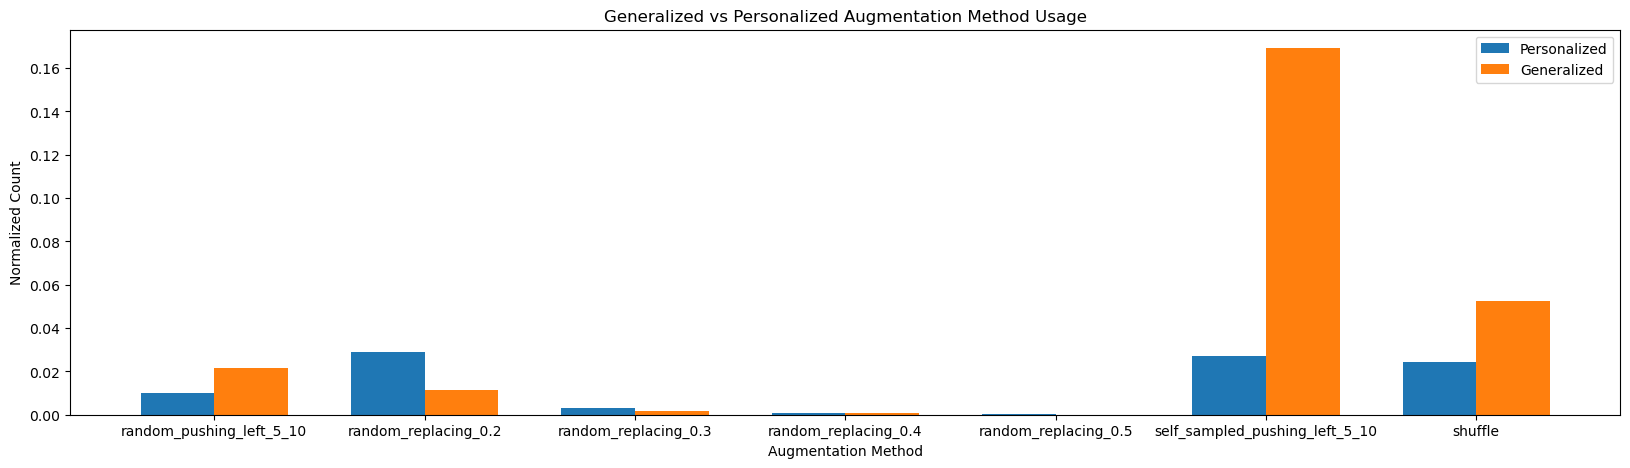

In [19]:
## exclude random_replacing method
popped_bin_key_words = ["random_pushing_left_5_10", "random_replacing_0.2", "random_replacing_0.3", "random_replacing_0.4", "random_replacing_0.5", "self_sampled_pushing_left_5_10", "shuffle"]

personalized_rank_counts_normalized.pop(1)
generalized_rank_counts_normalized.pop(1)

plt.figure(figsize=(20, 5))
## side by side
## personalization at the left
## generalization at the right
bar_width = 0.35
index = np.arange(7)
plt.bar(index, personalized_rank_counts_normalized, bar_width, label="Personalized")
plt.bar(index + bar_width, generalized_rank_counts_normalized, bar_width, label="Generalized")
plt.xticks(index + bar_width / 2, popped_bin_key_words)

plt.title("Generalized vs Personalized Augmentation Method Usage")

plt.xlabel("Augmentation Method")
plt.ylabel("Normalized Count")
plt.legend()
plt.show()

